In [ ]:
!pip install --upgrade pip

In [ ]:
%pip install nina-helper
%pip install PyWavelets
%pip install scikit-optimize

     |████████████████████████████████| 101 kB 3.0 MB/s 


In [ ]:
import platform
print(platform.python_version())


3.7.11


In [7]:
!pip list

Package                       Version
----------------------------- -------------------
absl-py                       0.12.0
alabaster                     0.7.12
albumentations                0.1.12
altair                        4.1.0
appdirs                       1.4.4
argon2-cffi                   20.1.0
arviz                         0.11.2
astor                         0.8.1
astropy                       4.2.1
astunparse                    1.6.3
async-generator               1.10
atari-py                      0.2.9
atomicwrites                  1.4.0
attrs                         21.2.0
audioread                     2.1.9
autograd                      1.3
Babel                         2.9.1
backcall                      0.2.0
beautifulsoup4                4.6.3
bleach                        3.3.0
blis                          0.4.1
bokeh                         2.3.3
Bottleneck                    1.3.2
branca                        0.4.2
bs4                           0.0.1
CacheCont

In [ ]:
from functools import reduce
import joblib
import matplotlib.pyplot as plt
from nina_helper import *
import numpy as np
import os
import pandas as pd
from pywt import *
from scipy.io import loadmat
from scipy import signal
import scipy as sp
from sklearn import svm, metrics
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV, ShuffleSplit, learning_curve, validation_curve
from sklearn.preprocessing import StandardScaler
from skopt import BayesSearchCV

import tensorflow.compat.v1 as tf

tf.config.set_soft_device_placement(True)
tf.debugging.set_log_device_placement(True)
from tensorflow import keras as K

In [ ]:
#rclone for HPC unless we use winSCP or alternative to transfer data
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
db2_path = "/content/drive/MyDrive/NINAPRO/DB2/"

##Loading Dataset##

In [ ]:
# Outlining for a single subject before altering for all subjects
################################################################################
# To Use all subjects, We could create a sklearn pipeline for construcingt the
# feature matrix X and labels y for each subject then concatenate the pd dataframes
# before creating test_train_splits and evaluating the classifiers and producing their validation curves

In [ ]:
# Choose subject and get info
subject = 2
info_dict = db2_info()  # Get info

# Get EMG, repetition and movement data, cap max length of rest data before and after each movement to 5 seconds
# Capping occurs by reducing the size of repetition segments since splitting is based on repetition number
data_dict = nina_helper.import_db2(db2_path, subject, rest_length_cap=5)

# Create a random test - training split based on repetition number (specify a set to include)
reps = info_dict['rep_labels']
nb_test_reps = 2
nb_splits = 12
train_reps, test_reps = gen_split_rand(reps, nb_test_reps, nb_splits, base=[2, 5])

# Normalise EMG data based on training set     train_reps[0, :]
emg_data = normalise_emg(data_dict['emg'], data_dict['rep'], train_reps[0, :])

In [ ]:
emg_data=pd.DataFrame(emg_data)

##PreProcessing##

1.   Filter (Band and notch)
2.   Windowing



##Filtering##

In [ ]:
def filter_data(data, f, butterworth_order = 4, btype='lowpass', fs=2000):
  emg_data = data.values[:,:12]
    
  nyquist = fs/2
  if isinstance(f, int):
      fc = f/nyquist
  else:
      fc = list(f)
      for i in range(len(f)):
          fc[i] = fc[i]/nyquist
            
  b,a = signal.butter(butterworth_order, fc, btype=btype)
  transpose = emg_data.T.copy()
    
  for i in range(len(transpose)):
      transpose[i] = (signal.lfilter(b, a, transpose[i]))
    
  filtered = pd.DataFrame(transpose.T)
    
  return filtered

In [ ]:
def notch_filter(data, f0, Q, fs=2000):
    emg_data = data.values[:,:12]
    
    b, a = signal.iirnotch(f0, Q, fs)
    transpose = emg_data.T.copy()
    
    for i in range(len(transpose)):
        transpose[i] = (signal.lfilter(b, a, transpose[i]))
    
    filtered = pd.DataFrame(transpose.T)
    
    
    return filtered

In [ ]:
emg_band = filter_data(data=emg_data, f=(0.5,200), butterworth_order=4, btype='bandpass', fs=2000)

In [ ]:
emg_notch = notch_filter(data=emg_band,f0=60,Q=30,fs=2000)

In [ ]:
emg_filtered = emg_notch.to_numpy()

##Windowing##

In [ ]:
os.chdir('/content/drive/MyDrive/Smart Wearable Devices: Summer Research/Software Team/SVC_saved_example')
#os.chdir('/content/drive/Shareddrives/Smart Wearable Devices: Summer Research/Software Team/SVC_saved_example')

In [ ]:
aggregate_labels_list = []
aggregate_test_labels_list = []

In [ ]:
aggregate_labels_list = np.load("aggregate_labels_list.npy")
aggregate_test_labels_list = np.load("aggregate_test_labels_list.npy")

In [ ]:
# Decide window length
window_len = 600  # Equivalent window length since sampled 20 times faster
window_inc = 20

# Window data: x_all data is 4D tensor [observation, time_step, channel, 1] for use with Keras
#y_all: movement label, length: number of windows
#r_all: repetition label, length: number of windows
# x_all, y_all, r_all = get_windows(reps, window_len, window_inc,
#                                   emg_filtered, data_dict['move'],
#                                   data_dict['rep'])

x_all, y_all, r_all = get_windows(reps, window_len, window_inc,
                                  emg_filtered, data_dict['move'],
                                  data_dict['rep'])

train_idx = get_idxs(r_all, train_reps[0, :])
X_train = np.squeeze(x_all[train_idx, :, :, :])
y_train = y_all[train_idx]
np.save("y_train_subject{}".format(subject), y_train)

test_idx = get_idxs(r_all, test_reps[0, :])
X_test =  np.squeeze(x_all[test_idx, :, :, :])
y_test = y_all[test_idx]
np.save("y_train_subject{}".format(subject), y_train)

In [ ]:
aggregate_labels_list.append(y_test)
aggregate_test_labels_list.append(y_test)

In [ ]:
aggregate_labels = np.hstack(aggregate_labels_list)
aggregate_test_labels = np.hstack(aggregate_test_labels_list)

In [ ]:
!python --version

Python 3.7.11


In [ ]:
aggregate_labels_list = np.append(aggregate_labels_list, y_train)
aggregate_test_labels_list = np.append(aggregate_test_labels_list, y_test)

In [ ]:
w = np.hstack((y_train,y_test))

In [ ]:
print (w.shape, np.transpose(w).shape)

(261358,) (261358,)


In [ ]:
aggregate_labels_list.shape

(176402,)

In [ ]:
print(aggregate_labels_list)

[ 0.  0.  0. ... 49. 49. 49.]


In [ ]:
abc = aggregate_labels_list

In [ ]:
abc = int(abc)
print(abc)

TypeError: ignored

In [ ]:
print(y_train)

[ 0  0  0 ... 49 49 49]


In [ ]:
print(aggregate_labels_list.shape)
a = np.transpose(aggregate_labels_list).shape
print(a)

(614162,)
(614162,)


In [ ]:
np.save("aggregate_labels_list", aggregate_labels_list)
np.save("aggregate_test_labels_list", aggregate_test_labels_list)

In [ ]:
agg_list_test = []

In [ ]:
aggregate_labels_list = np.vstack((y_train, y_test))

ValueError: ignored

##Features##


1.   Time Domain
2.   Frequency Domain (Summary Statistics Optional)
3.   Feature Matrix



In [ ]:
from tqdm import tqdm

def feature_extractor(features,shape,data):
  l=pd.DataFrame()
  for i,function in enumerate(tqdm(features)):
        feature=[]
        print("Extracting feature....{}".format(str(function)))
        for i in range(data.shape[0]):
          for j in range(data.shape[2]):
                feature.append(function(data[i][:,j]))
        feature = np.reshape(feature,shape)
        l = pd.concat([l,pd.DataFrame(feature)],axis=1)
        print("Done extracting feature....{}".format(str(function)))
        print()
  return l


##Time Domain##

In [ ]:
def rms(data):
  return np.sqrt(np.mean(data**2))

def hist(data, nbins=20):
  histsig, bin_edges = np.histogram(data, bins = nbins)
  return tuple(histsig)

def mdwt(data):
  cA_3, cD_3, cD_2, cD_1 = wavedec(data,'db7', level=3)
  return cA_3

def entropy(data):
  pk = sp.stats.rv_histogram(np.histogram(data, bins=20)).pdf(data)
  return  sp.stats.entropy(pk)

def kurtosis(data):
  return sp.stats.kurtosis(data)

def zero_cross(data):
  return len(np.where(np.diff(np.sign(data)))[0])/len(data)

def min(data):
  return np.min(data)

def max(data):
  return np.max(data)

def mean(data):
  return np.mean(data)

def median(data):
  return np.median(data)


##Frequency Domain##

In [ ]:
def fft(data):
  return np.fft.fft(data)

def psd(data):
  return np.abs(np.fft.fft(data))**2

##Feature Matrix##

In [ ]:
def pca(data):
    pca=PCA(n_components=600)
    pca.fit(data)
    x_pca=pca.transform(data)
    return pd.DataFrame(x_pca)

In [ ]:
features_required = [rms,hist,mdwt,entropy,zero_cross,min,max,mean,median] #change this list depending on the features required in the final feature matrix

In [ ]:
feature_matrix = feature_extractor(features_required,(X_train.shape[0],-1),X_train)

In [ ]:
test_feature_matrix = feature_extractor(features_required,(X_test.shape[0],-1),X_test)

In [ ]:
reduced_feature_matrix = pca(feature_matrix)

In [ ]:
reduced_test_feature_matrix = pca(test_feature_matrix)

In [ ]:
#Loop the above concatinating to pd.DataFrame

##Classifiers##

1.   Hyperparameter Optimization (GridSearchCV, BayesSearchCV) 
2.   SVM
3.   Random Forest
4.   LDA
5.   Learning Curves (includes cross validation, ensures classifier accuracy wasn't a result of the statistical lottery) 
6.   Validation Curves (shows the score with respect to some varying hyperparameter, visualize confirmation from hyperparameter optimization)
7.   MAKE SURE WE SAVE OUR MODELS AND PLOTS, models can be saved with scipy joblib



In [ ]:
def get_validation_curve(classifier,parameter,param_range,X,y): # A generalized function to plot validation curve for all 3 classifiers.
  train_scores, test_scores = validation_curve(
    classifier, X, y, param_name=parameter, param_range=param_range,
    scoring="accuracy", n_jobs=1)
  train_scores_mean = np.mean(train_scores, axis=1)
  train_scores_std = np.std(train_scores, axis=1)
  test_scores_mean = np.mean(test_scores, axis=1)
  test_scores_std = np.std(test_scores, axis=1)

  plt.title("Validation Curve with {}".format(classifier.__class__.__name__))
  plt.xlabel(str(parameter))
  plt.ylabel("Score")
  plt.ylim(0.0, 1.1)
  lw = 2
  plt.semilogx(param_range, train_scores_mean, label="Training score",
              color="darkorange", lw=lw)
  plt.fill_between(param_range, train_scores_mean - train_scores_std,
                  train_scores_mean + train_scores_std, alpha=0.2,
                  color="darkorange", lw=lw)
  plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
              color="navy", lw=lw)
  plt.fill_between(param_range, test_scores_mean - test_scores_std,
                  test_scores_mean + test_scores_std, alpha=0.2,
                  color="navy", lw=lw)
  plt.legend(loc="best")

  return plt

In [ ]:
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : estimator instance
        An estimator instance implementing `fit` and `predict` methods which
        will be cloned for each validation.

    title : str
        Title for the chart.

    X : array-like of shape (n_samples, n_features)
        Training vector, where ``n_samples`` is the number of samples and
        ``n_features`` is the number of features.

    y : array-like of shape (n_samples) or (n_samples, n_features)
        Target relative to ``X`` for classification or regression;
        None for unsupervised learning.

    axes : array-like of shape (3,), default=None
        Axes to use for plotting the curves.

    ylim : tuple of shape (2,), default=None
        Defines minimum and maximum y-values plotted, e.g. (ymin, ymax).

    cv : int, cross-validation generator or an iterable, default=None
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, default=None
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like of shape (n_ticks,)
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the ``dtype`` is float, it is regarded
        as a fraction of the maximum size of the training set (that is
        determined by the selected validation method), i.e. it has to be within
        (0, 1]. Otherwise it is interpreted as absolute sizes of the training
        sets. Note that for classification the number of samples usually have
        to be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")
    
    return plt


# fig, axes = plt.subplots(3, 2, figsize=(10, 15))

# X, y = load_digits(return_X_y=True)

# title = "Learning Curves (Naive Bayes)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
# cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

# estimator = GaussianNB()
# plot_learning_curve(estimator, title, X, y, axes=axes[:, 0], ylim=(0.7, 1.01),
                    # cv=cv, n_jobs=4)



In [ ]:
# Changing directory to somewhere to save the models
import os
os.chdir('/content/drive/MyDrive/NINAPRO/DB2_data/')

##SVM##

In [ ]:
# Hyperparameter Tuning for SVM
opt = BayesSearchCV(
    svm.SVC(),
    {'C': (1e-6, 1e+6, 'log-uniform'),
        'gamma': (1e-6, 1e+1, 'log-uniform'),
        'degree': (1, 8),  # integer valued parameter
        'kernel': ['linear', 'poly', 'rbf'],  # categorical parameter
     },
    n_iter=32,
    cv=3
)

opt_2 = GridSearchCV(
    svm.SVC(),
    {'C': [1,10],
        'gamma': [1e-6, 1e-4, 1e-3, 1e+1],
        'degree': (1, 8),  # integer valued parameter
        'kernel': ['linear', 'poly', 'rbf'],  # categorical parameter
     },
    cv=3
)

opt.fit(aggregate_principal_matrix , y_train)

estimator = opt.best_estimator_

# Save Optimal Model
joblib.dump(estimator,'{}_opt_model'.format(estimator.__class__.__name__))

# Save Report
y_pred= estimator.predict(aggregate_test_principal_matrix)
report = classification_report(y_test, y_pred)
joblib.dump(report,'{}_classification_report'.format(estimator.__class__.__name__))

# Save Plots
################################################################################
# Validation Curve of SVM
param_range = np.logspace(-6, -1, 5)
get_validation_curve(estimator, "gamma",param_range, aggregate_principal_matrix , y_train)
plt.savefig("{}_validation_curve.jpg".format(estimator.__class__.__name__))

# Learning Curve of SVM
fig, axes = plt.subplots(3, 1, figsize=(10, 15))
title = r"Learning Curves (SVM)"
# SVC is more expensive so we do a lower number of CV iterations:
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)

plot_learning_curve(estimator, title, aggregate_principal_matrix , y_train, axes=axes[:], ylim=(0.7, 1.01),
                    cv=cv, n_jobs=4)

plt.savefig("{}_learning_curve.jpg".format(estimator.__class__.__name__))
################################################################################


##Random Forest##

In [ ]:
# Hyperparameter Tuning for RandomForestClassifier
opt = BayesSearchCV(
    RandomForestClassifier(),
    {'n_estimators': [int(x) for x in np.linspace(start = 100, stop = 2000, num = 20)],
     'max_features': ['auto', 'sqrt'],
     'max_depth': [int(x) for x in np.linspace(10, 110, num = 11)],
     'min_samples_split': [2, 5, 10],
     'min_samples_leaf': [1, 2, 4],
     'bootstrap': [True, False],
     },
    n_iter=32,
    cv=3
)

opt.fit(aggregate_principal_matrix, y_train)

estimator = opt.best_estimator_

# Save Optimal Model
joblib.dump(estimator,'{}_opt_model'.format(estimator.__class__.__name__))

# Save Report
y_pred= estimator.predict(aggregate_test_principal_matrix)
report = classification_report(y_test,y_pred)
joblib.dump(report,'{}_classification_report'.format(estimator.__class__.__name__))

# Save Plots
################################################################################
# Validation Curve of Random Forest Classifier
param_range = np.arange(1, 250, 2)
get_validation_curve(estimator, "n_estimators",param_range, aggregate_principal_matrix, y_train)
plt.savefig("{}_validation_curve.jpg".format(estimator.__class__.__name__))

# Learning Curve of RandomForestClassifier
fig, axes = plt.subplots(3, 1, figsize=(10, 15))
title = r"Learning Curves (RandomForestClassifier)"

cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)

plot_learning_curve(estimator, title, aggregate_principal_matrix, y_train, axes=axes[:], ylim=(0.7, 1.01),
                    cv=cv, n_jobs=4)

plt.savefig("{}_learning_curve.jpg".format(estimator.__class__.__name__))
################################################################################

##LDA##

In [ ]:
# Hyperparameter Tuning for LDA
opt = BayesSearchCV(
    LinearDiscriminantAnalysis(),
    {'solver': ['svd', 'lsqr', 'eigen'],
    },
    n_iter=32,
    cv=3
)

opt.fit(aggregate_principal_matrix, y_train)

estimator = opt.best_estimator_

# Save Optimal Model
joblib.dump(estimator,'{}_opt_model'.format(estimator.__class__.__name__))

# Save Report
y_pred= estimator.predict(aggregate_test_principal_matrix)
report = classification_report(y_test, y_pred)
joblib.dump(report,'{}_classification_report'.format(estimator.__class__.__name__))

# Save Plots
################################################################################
# Validation Curve of LDA
grid= ['svd', 'lsqr', 'eigen']
get_validation_curve(estimator,'solver' ,grid, aggregate_principal_matrix, y_train)
plt.savefig("{}_validation_curve.jpg".format(estimator.__class__.__name__))

# Learning Curve of LDA
fig, axes = plt.subplots(3, 1, figsize=(10, 15))
title = r"Learning Curves (LDA)"

cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)

plot_learning_curve(estimator, title, aggregate_principal_matrix, y_train, axes=axes[:], ylim=(0.7, 1.01),
                    cv=cv, n_jobs=4)

plt.savefig("{}_learning_curve.jpg".format(estimator.__class__.__name__))
################################################################################

##Convenience Testing Area##

1.   Begin by Mounting your google drive and importing packages above
2.   Follow the example below to navigate to the group folder
2.   Load train and test feature matrix data and labels or
2.   Pick 'principal_' for 15 column or the 'reduced_' for 600 column




In [ ]:
os.chdir('/content/drive/MyDrive/Smart Wearable Devices: Summer Research/Software Team/SVC_saved_example')
#os.chdir('/content/drive/Shareddrives/Smart Wearable Devices: Summer Research/Software Team/SVC_saved_example')

In [ ]:
# feature_matrix = np.load("feature_matrix.npy")
# test_feature_matrix = np.load("test_feature_matrix.npy")

In [ ]:
y_test_S1 = np.load('y_test.npy')
y_pred_S1 = np.load('y_pred_SVC_principal_feature_model.npy')

In [ ]:
# 15 Principal Features
principal_1 = np.load('principal_feature_matrix.npy') 
principal_test_1 = np.load('principal_test_feature_matrix.npy')

principal_2 = np.load('principal_feature_matrix.npy') 
principal_2 = np.hstack((principal_1, principal_2))
principal_test_2 = np.load('principal_test_feature_matrix.npy')
principal_test_2 = np.vstack((principal_test_1, principal_test_2))


In [ ]:
principal_1.shape, principal_2.shape

((176550, 15), (176550, 30))

In [ ]:
p2 = pca_feat(principal_2, 15)
p2.shape

(176550, 15)

In [ ]:
agg_list = []
agg_list.append(principal_1)
agg_list.append(principal_2)


In [ ]:
def vstack_dim_helper(agg_list):
  def pca_feat(data, n_components):
      pca=PCA(n_components)
      pca.fit(data)
      x_pca=pca.transform(data)
      return pd.DataFrame(x_pca)

  agg_dims = []

  for mat in agg_list:
    agg_dims.append(mat.shape[1])
  min_dim = min(agg_dims)

  for mat in range(len(agg_list)):
    if agg_list[mat].shape[1] > min_dim:
      agg_list[mat] = pca_feat(agg_list[mat], min_dim)
  return agg_list


In [ ]:
agg_list = vstack_dim_helper(agg_list)
agg = np.vstack(agg_list)
agg.shape

(353100, 15)

In [ ]:
for mat in agg_list:
  print(mat.shape)

(176550, 15)
(176550, 15)


In [ ]:
# 600 Principal Features
# reduced_feature_matrix = np.load("reduced_feature_matrix.npy")
# reduced_test_feature_matrix = np.load("reduced_test_feature_matrix.npy")

In [ ]:
s2_train_label = y_train
s2_test_label = y_test

In [ ]:
s1_train_label = np.load("y_train.npy")
s1_test_label = np.load("y_test.npy")

In [ ]:
y_train.shape, y_test.shape

((176550,), (84999,))

In [ ]:
# Example of saving the model, the y_pred array, the classification_report

# clf1 = svm.SVC(kernel='rbf', C=10, random_state=42)
# clf1.fit(principal_feature_matrix,y_train)
# joblib.dump(clf1,'SVC_principal_feature_model')

# y_pred=clf1.predict(principal_test_feature_matrix)
# np.save('y_pred_SVC_principal_feature_model', y_pred)

# report = classification_report(y_test,y_pred)
# joblib.dump(report,'classification_report_principal_feat_model')

# print(report)

In [ ]:
# Example of loading model object, report and y_pred array

loaded_svm_model = joblib.load('SVC_principal_feature_model')
# y_pred_SVC = np.load('y_pred_SVC_principal_feature_model.npy')
SVC_principal_report = joblib.load('classification_report_principal_feat_model')

In [ ]:
def read_csv(path):
  # Read csv
  data=pd.read_csv(path)
  data=data.drop('Unnamed: 0',axis=1)
  return data


def Statistics(data):  
  # Classification Report 
  print("Classification Report is shown below")
  print(classification_report(data['actual labels'],data['predicted labels']))

  # Confusion matrix
  print("Confusion matrix is shown below")
  cm=confusion_matrix(data['actual labels'],data['predicted labels'])

  plt.figure(figsize=(10,7))
  sn.heatmap(cm, annot=True,cmap='Blues', fmt='g')
  plt.xlabel('Predicted')
  plt.ylabel('Truth')


In [ ]:
print(SVC_principal_report)

In [ ]:
#read_csv()
Statistics(SVC_principal_report)

In [ ]:
# View the saved report
print(SVC_principal_report)

In [ ]:
principal_feature_matrix.shape, principal_test_feature_matrix.shape

((176550, 15), (84999, 15))

In [ ]:
######### Testing that the scheme for stacking feature matrix works#############

number_of_subjects = 40
aggregate_principal_matrix_list = []
aggregate_test_principal_matrix_list = []

for subject in range(1,number_of_subjects+1):  
  aggregate_principal_matrix_list.append(principal_feature_matrix)
  aggregate_test_principal_matrix_list.append(principal_test_feature_matrix)

aggregate_principal_matrix = np.vstack(aggregate_principal_matrix_list)
aggregate_test_principal_matrix = np.vstack(aggregate_test_principal_matrix_list)

In [ ]:
aggregate_principal_matrix.shape, aggregate_test_principal_matrix.shape

((7062000, 15), (3399960, 15))

In [ ]:
!pwd


/content/drive/My Drive/Smart Wearable Devices: Summer Research/Software Team/SVC_saved_example


(window length, window inc) = (600, 45)


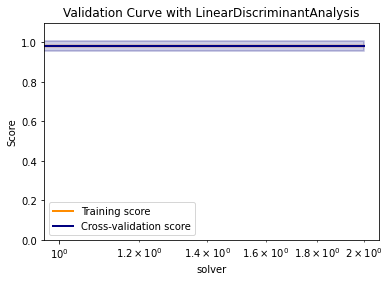

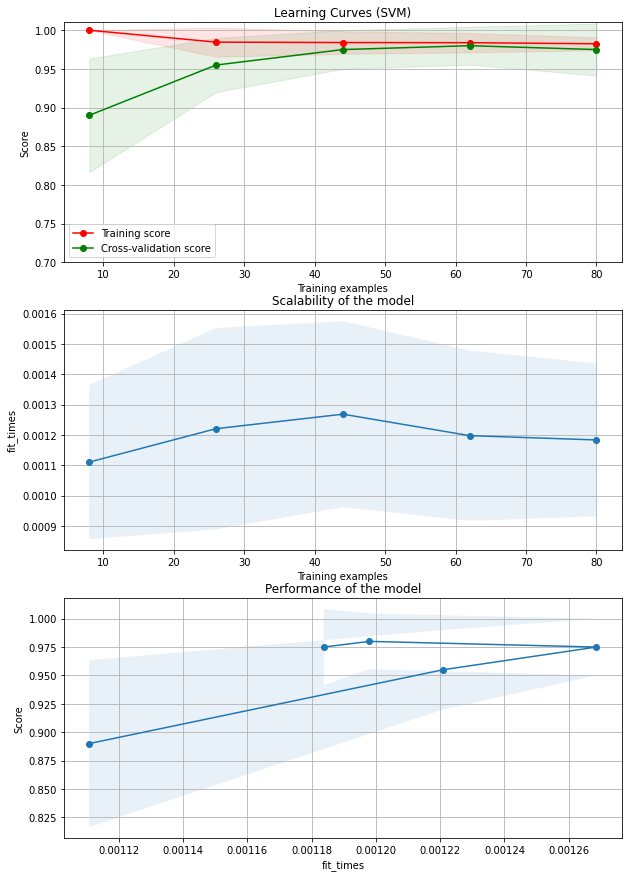

(window length, window inc) = (400, 30)


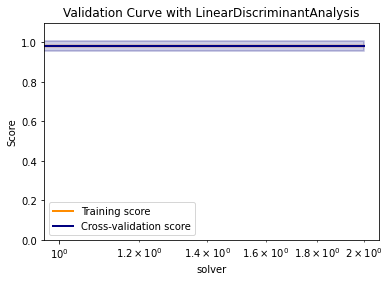

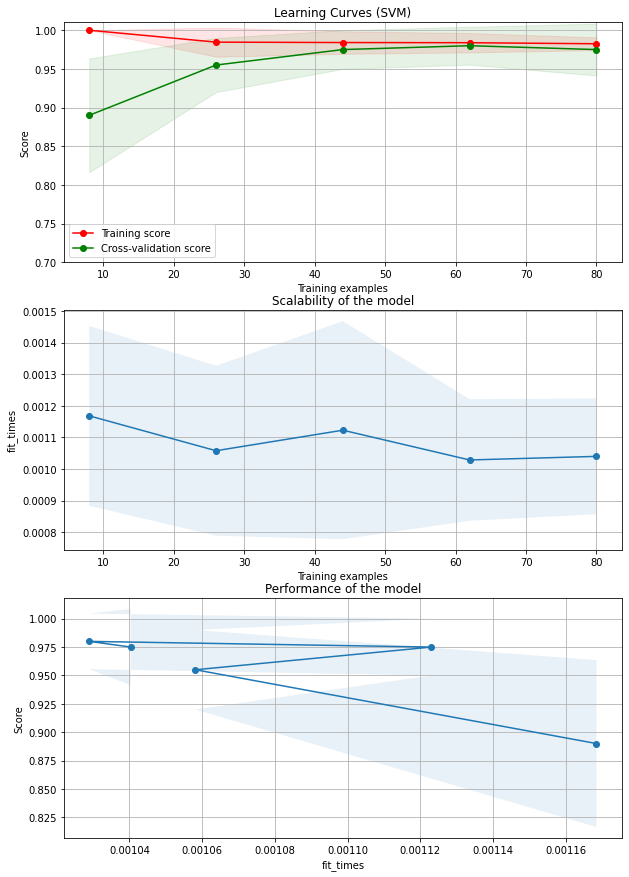

(window length, window inc) = (200, 15)


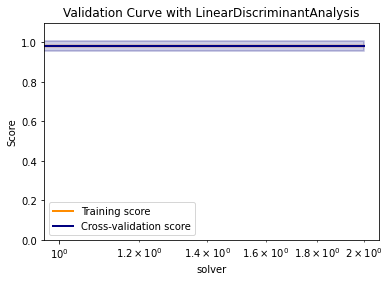

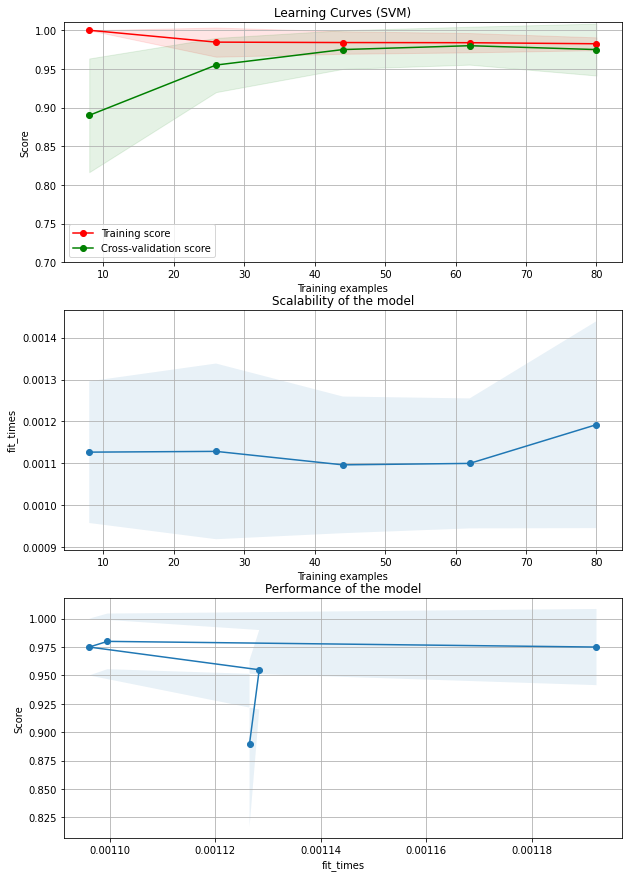

In [ ]:
from sklearn.model_selection import train_test_split
from skopt import BayesSearchCV
from sklearn import svm, datasets
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

##########################################################################
import warnings # DO NOT USE THIS WHILE TESTING
warnings.filterwarnings("ignore") # DO NOT USE THIS WHILE TESTING
###########################################################################

######## Verifying file names while changing windows #######################

# load data
iris = datasets.load_iris()
###############################################################################
# This is a toy dataset for classification, windows are technically meaningless here
##############################################################################
X_train, X_test, y_train, y_test = train_test_split( iris.data, iris.target, test_size=0.33, random_state=42)

#Since sample rate is 2000 Hz -> window length 2 = 1 ms
window_len_list = [600, 400, 200]
# These window increments all maintain 92.5% overlap
window_inc_list = [45, 30, 15]


for window in range(len(window_len_list)):
  window_len = window_len_list[window]
  window_inc = window_inc_list[window]
  print("(window length, window inc) =", (window_len, window_inc))

  # Hyperparameter Tuning for SVM
  # opt = GridSearchCV(
  #     svm.SVC(),
  #     {'C': [1,10],
  #         'gamma': [1e-6, 1e-4, 1e-3, 1e+1],
  #         'degree': (1, 8),  # integer valued parameter
  #         'kernel': ['linear', 'poly', 'rbf'],  # categorical parameter
  #     },
  #     cv=3
  # )
  # opt = GridSearchCV(
  #   RandomForestClassifier(),
  #   {'n_estimators': [int(x) for x in np.linspace(start = 100, stop = 1000, num = 5)],
  #    'max_features': ['auto', 'sqrt'],
  #    'max_depth': [int(x) for x in np.linspace(10, 100, num = 3)],
  #    'min_samples_split': [2, 5, 10],
  #    'min_samples_leaf': [1, 2, 4],
  #    'bootstrap': [True, False],
  #    },
  #   cv=3
  # )
  opt = BayesSearchCV(
    LinearDiscriminantAnalysis(),
    {'solver': ['svd', 'lsqr', 'eigen'],
    },
    cv=3
  
  )
  opt.fit(X_train, y_train)

  estimator = opt.best_estimator_

  # Save Optimal Model
  joblib.dump(estimator,'{}_opt_model_{}{}'.format(estimator.__class__.__name__,int(window_len/2),'ms'))

  # Save Report
  y_pred= estimator.predict(X_test)
  report = classification_report(y_test, y_pred, output_dict=True)
  joblib.dump(report,'{}_classification_report__dict{}{}'.format(estimator.__class__.__name__,int(window_len/2),'ms'))

  # Save Plots (2/2)
  ################################################################################
  # Validation Curve of SVC
  # param_range = np.logspace(-6, -1, 5)
  # get_validation_curve(estimator, "gamma"

  # param_range = np.arange(1, 250, 2)
  # get_validation_curve(estimator, "n_estimators",param_range, X_train, y_train)
  # plt.savefig("{}_validation_curve_{}{}.jpg".format(estimator.__class__.__name__,int(window_len/2),'ms'))


  grid= ['svd', 'lsqr', 'eigen']
  get_validation_curve(estimator,'solver' ,grid, X_train, y_train)
  plt.savefig("{}_validation_curve_{}{}.jpg".format(estimator.__class__.__name__,int(window_len/2),'ms'))

                     
  # Learning Curve of SVM
  fig, axes = plt.subplots(3, 1, figsize=(10, 15))
  title = r"Learning Curves (SVM)"
  # SVC is more expensive so we do a lower number of CV iterations:
  cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)

  plot_learning_curve(estimator, title, X_train, y_train, axes=axes[:], ylim=(0.7, 1.01),
                      cv=cv, n_jobs=4)

  plt.savefig("{}_learning_curve.jpg".format(estimator.__class__.__name__))
  ################################################################################
  plt.show()

In [ ]:
from sklearn.metrics import balanced_accuracy_score   
from sklearn.metrics import accuracy_score
import seaborn as sns

def Statistics(data):  
  # Classification Report 
  report = classification_report(data['actual labels'],data['predicted labels'],output_dict=True)
  report = pd.DataFrame(report).T
  # Confusion matrix
  print("Confusion matrix is shown below")
  c_matrix=confusion_matrix(data['actual labels'],data['predicted labels'])
  FP = c_matrix.sum(axis=0) - np.diag(c_matrix) 
  FN = c_matrix.sum(axis=1) - np.diag(c_matrix)
  TP = np.diag(c_matrix)
  TN = c_matrix.sum() - (FP + FN + TP)
  FP = FP.astype(float)
  FN = FN.astype(float)
  TP = TP.astype(float)
  TN = TN.astype(float)
  # Sensitivity or positive recall
  TPR = TP/(TP+FN)
  # Specificity or true negative rate or negative recall
  TNR = TN/(TN+FP) 
  accuracy = accuracy_score(data['actual labels'],data['predicted labels'])
  TNR = np.append(TNR,[accuracy, TNR.mean(), ((TNR * report['support'][:50]).sum())/(report['support'][:50].sum())])
  report['specificity'] = TNR # adding new column specificity
  plt.figure(figsize=(40,20))
  norm_c_matrix = c_matrix.astype('float') / c_matrix.sum(axis=1)[:, np.newaxis]
  sns.heatmap(norm_c_matrix, annot=True,cmap='Blues', fmt='.2f')
  #sns.heatmap(c_matrix, annot=True,cmap='Blues', fmt='g')
  plt.xlabel('Predicted')
  plt.ylabel('Truth')
  print("Balanced_accuracy:{}".format(balanced_accuracy_score(data['actual labels'],data['predicted labels'])))
  print("Classification Report is shown below")
  return report, c_matrix, norm_c_matrix

In [ ]:
data = []
data.append(y_test_S1)
data.append(y_pred_S1)

In [ ]:
data = np.vstack(data).T

In [ ]:
data_df = pd.DataFrame(data, columns = ['actual labels', 'predicted labels'])
#data_df.drop_duplicates(inplace=True)

In [ ]:
data = data_df

Confusion matrix is shown below
Balanced_accuracy:0.18960868763753047
Classification Report is shown below


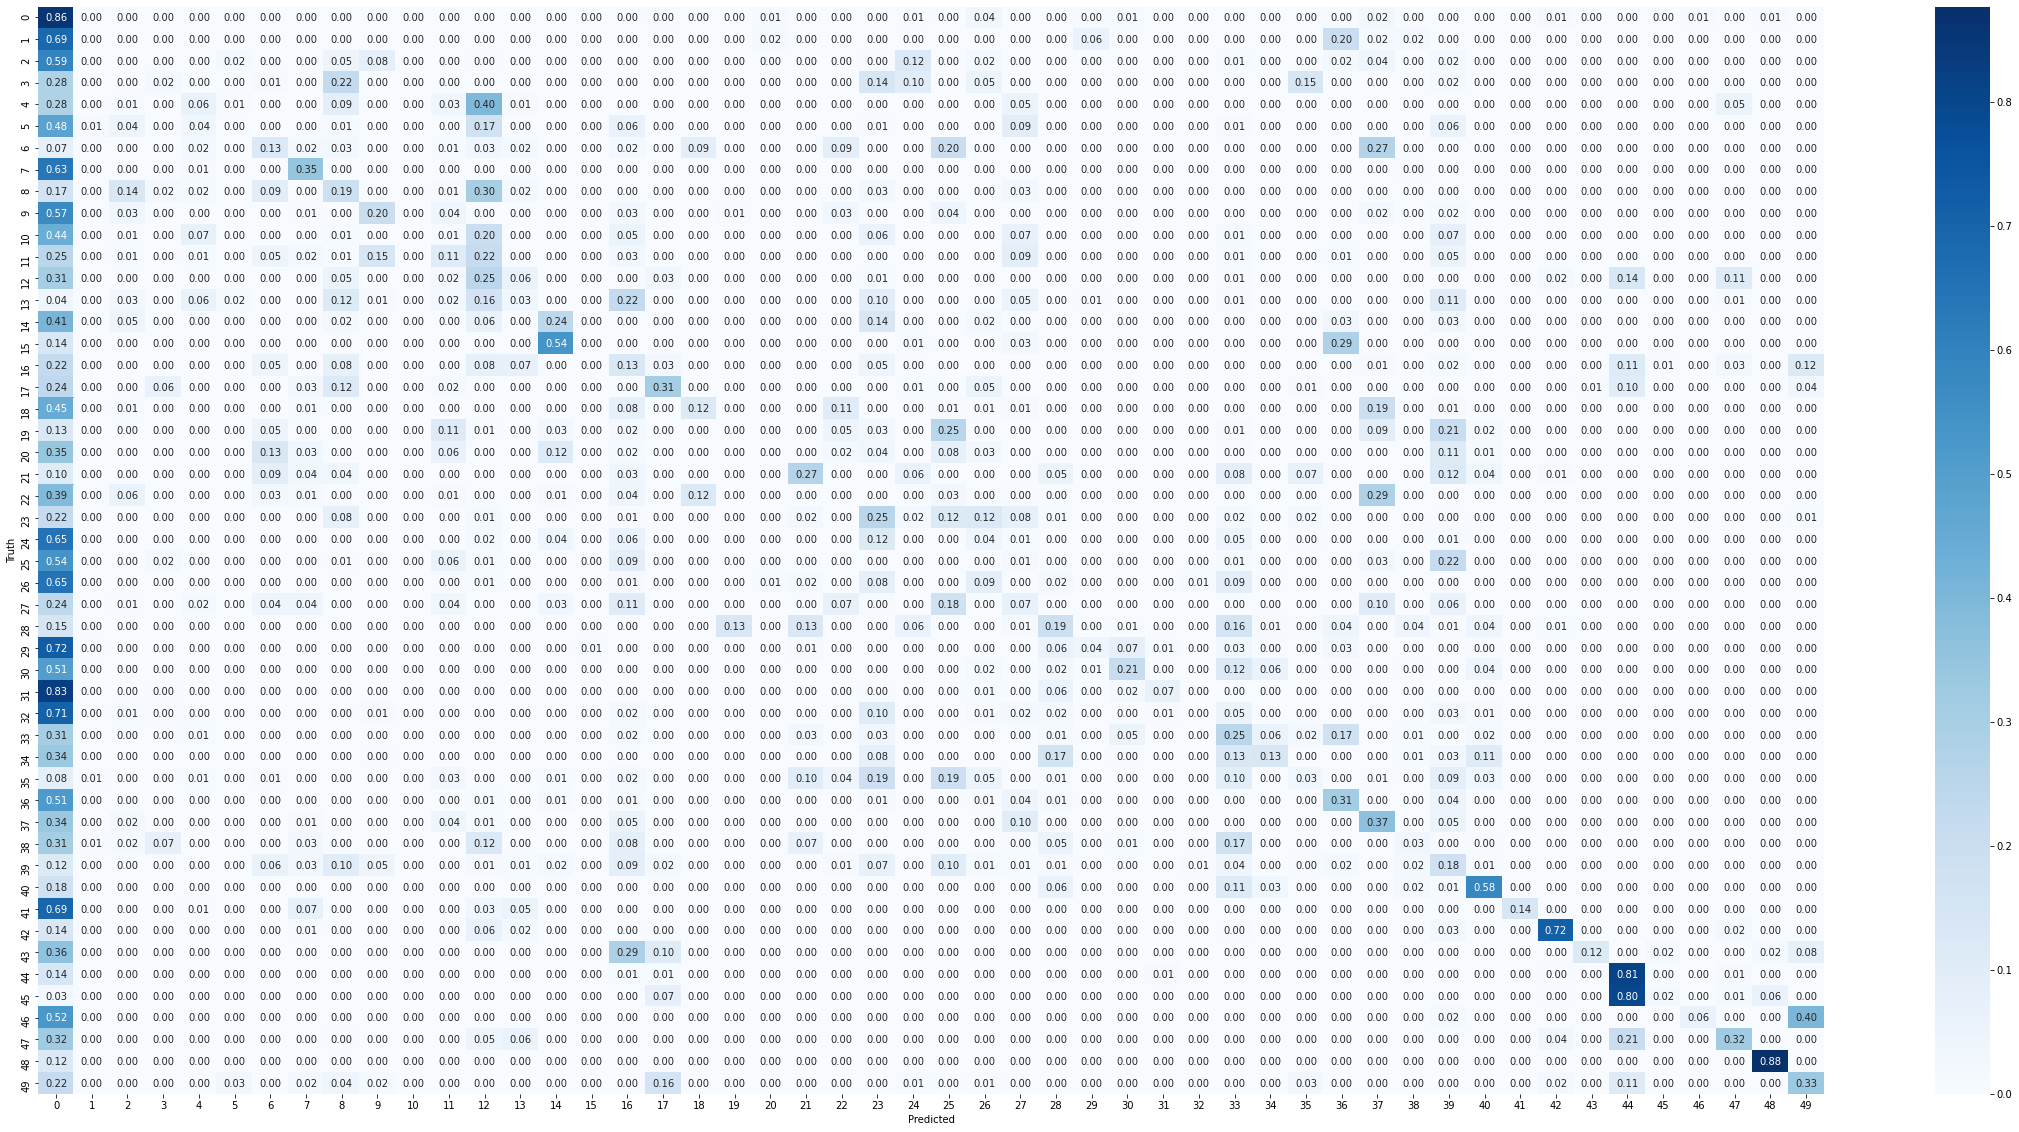

In [ ]:
rep, c_mat, norm_c_mat = Statistics(data)

Text(339.0, 0.5, 'Truth')

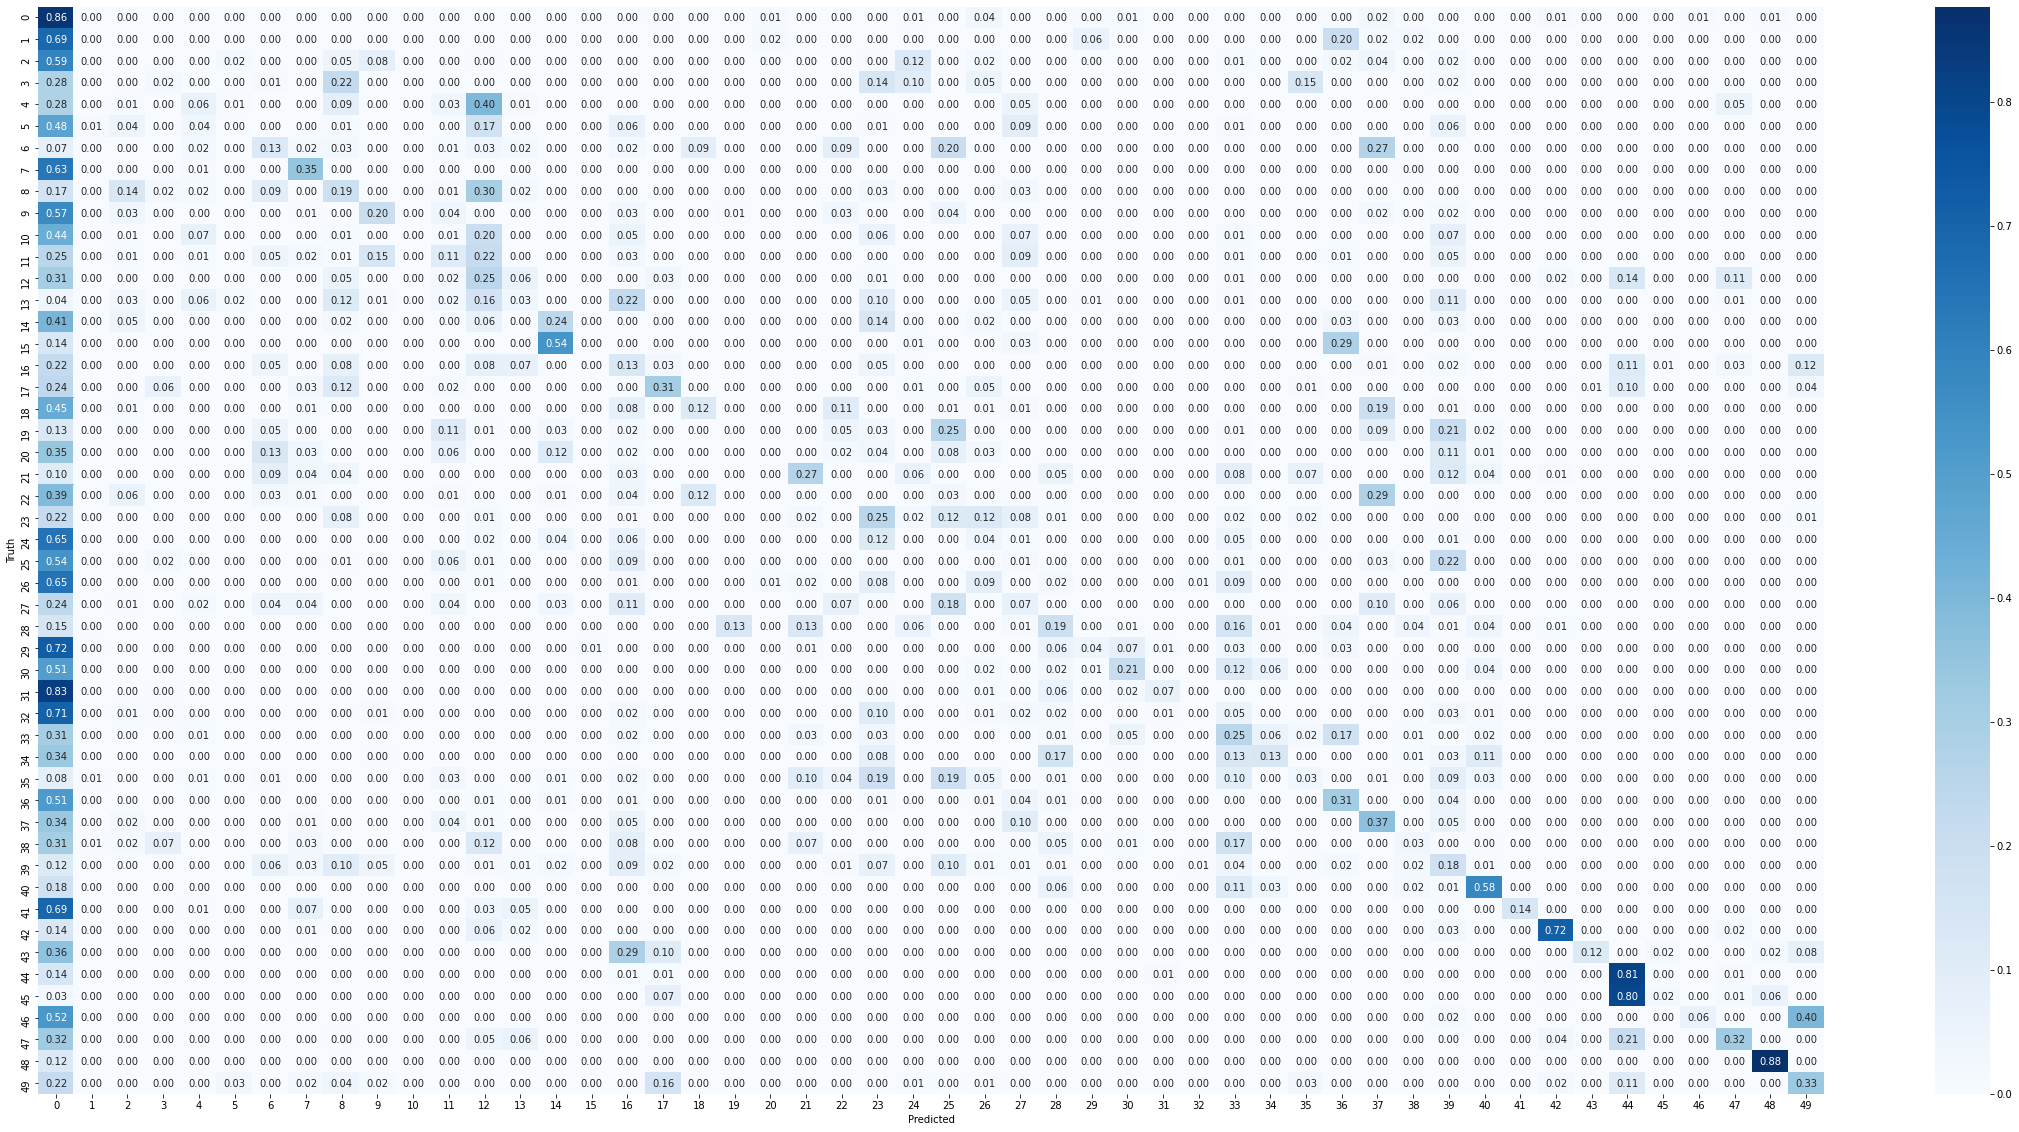

In [ ]:
plt.figure(figsize=(40,20))
sns.heatmap(norm_c_mat, annot=True,cmap='Blues', fmt='.2f')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [ ]:
import sklearn 
print (sklearn.__version__)

0.22.2.post1


In [ ]:
SVC_toy_report = joblib.load('SVC_classification_report__dict100ms')

In [ ]:
SVC_toy_report

{'0': {'f1-score': 1.0, 'precision': 1.0, 'recall': 1.0, 'support': 19},
 '1': {'f1-score': 1.0, 'precision': 1.0, 'recall': 1.0, 'support': 15},
 '2': {'f1-score': 1.0, 'precision': 1.0, 'recall': 1.0, 'support': 16},
 'accuracy': 1.0,
 'macro avg': {'f1-score': 1.0,
  'precision': 1.0,
  'recall': 1.0,
  'support': 50},
 'weighted avg': {'f1-score': 1.0,
  'precision': 1.0,
  'recall': 1.0,
  'support': 50}}

In [ ]:
toy_report = pd.DataFrame(SVC_toy_report).T
toy_report

,precision,recall,f1-score,support
0,1.0,1.0,1.0,19.0
1,1.0,1.0,1.0,15.0
2,1.0,1.0,1.0,16.0
accuracy,1.0,1.0,1.0,1.0
macro avg,1.0,1.0,1.0,50.0
weighted avg,1.0,1.0,1.0,50.0


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score

labels=y_train.unique()          #or y_all.unique()
y = label_binarize(y_train, classes=labels)      
n_classes = y.shape[1]
x= aggregate_principal_matrix

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=.5,
                                                    random_state=0)

In [ ]:
classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True, gamma=0.001,
                                 random_state=0))
y_score_svc = classifier.fit(X_train, y_train).decision_function(X_test)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score_svc[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test[:].ravel(), y_score_svc.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [ ]:
from sklearn.ensemble import RandomForestClassifier
classifier = OneVsRestClassifier(RandomForestClassifier(min_samples_leaf=5))
classifier.fit(X_train, y_train)
y_score_rfc=classifier.predict(X_test)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score_rfc[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test[:].ravel(), y_score_rfc.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
classifier = OneVsRestClassifier(LinearDiscriminantAnalysis())
classifier.fit(X_train, y_train)
y_score_lda=classifier.predict(X_test)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score_lda[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test[:].ravel(), y_score_lda.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

##Depricated##

In [ ]:
"clf = svm.SVC()
clf.fit(X_train, y_train) # I guess we could replace X_train by the feature_matrix. This perhaps needs to be changed for all models
y_pred = clf.predict(X_test) # Similarly X_test could be replaced by test_feature_matrix. Any opinion?

In [ ]:
print("Test Accuracy SVM:", metrics.accuracy_score(y_test, y_pred))

Test Accuracy: 0.5393105206142866


In [ ]:
save_model(clf,"SVM.sav")

In [ ]:
clf = RandomForestClassifier(min_samples_leaf=5)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [ ]:
print("Test Accuracy RF:", metrics.accuracy_score(y_test, y_pred))

In [ ]:
save_model(clf,"Random_Forest.sav")

In [ ]:
clf = LinearDiscriminantAnalysis()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [ ]:
print("Test Accuracy LDA:", metrics.accuracy_score(y_test, y_pred))

In [ ]:
save_model(clf,"LDA.sav")

In [ ]:
from sklearn.model_selection import validation_curve

def get_validation_curve(classifier,parameter,param_range,X,y): # A generalized function to plot validation curve for all 3 classifiers.
  train_scores, test_scores = validation_curve(
    classifier, X, y, param_name=parameter, param_range=param_range,
    scoring="accuracy", n_jobs=1)
  train_scores_mean = np.mean(train_scores, axis=1)
  train_scores_std = np.std(train_scores, axis=1)
  test_scores_mean = np.mean(test_scores, axis=1)
  test_scores_std = np.std(test_scores, axis=1)

  plt.title("Validation Curve with {}".format(classifier.__class__.__name__))
  plt.xlabel(str(parameter))
  plt.ylabel("Score")
  plt.ylim(0.0, 1.1)
  lw = 2
  plt.semilogx(param_range, train_scores_mean, label="Training score",
              color="darkorange", lw=lw)
  plt.fill_between(param_range, train_scores_mean - train_scores_std,
                  train_scores_mean + train_scores_std, alpha=0.2,
                  color="darkorange", lw=lw)
  plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
              color="navy", lw=lw)
  plt.fill_between(param_range, test_scores_mean - test_scores_std,
                  test_scores_mean + test_scores_std, alpha=0.2,
                  color="navy", lw=lw)
  plt.legend(loc="best")
  plt.savefig("validation_curve_{}.jpg".format(classifier.__class__.__name__))
  plt.show()

In [ ]:
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit #can also use K-fold stratified or some other cv generator


def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : estimator instance
        An estimator instance implementing `fit` and `predict` methods which
        will be cloned for each validation.

    title : str
        Title for the chart.

    X : array-like of shape (n_samples, n_features)
        Training vector, where ``n_samples`` is the number of samples and
        ``n_features`` is the number of features.

    y : array-like of shape (n_samples) or (n_samples, n_features)
        Target relative to ``X`` for classification or regression;
        None for unsupervised learning.

    axes : array-like of shape (3,), default=None
        Axes to use for plotting the curves.

    ylim : tuple of shape (2,), default=None
        Defines minimum and maximum y-values plotted, e.g. (ymin, ymax).

    cv : int, cross-validation generator or an iterable, default=None
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, default=None
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like of shape (n_ticks,)
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the ``dtype`` is float, it is regarded
        as a fraction of the maximum size of the training set (that is
        determined by the selected validation method), i.e. it has to be within
        (0, 1]. Otherwise it is interpreted as absolute sizes of the training
        sets. Note that for classification the number of samples usually have
        to be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    plt.savefig("learning_curve_{}.jpg".format(estimator.__class__.__name__))
    return plt


# fig, axes = plt.subplots(3, 2, figsize=(10, 15))

# X, y = load_digits(return_X_y=True)

# title = "Learning Curves (Naive Bayes)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
# cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

# estimator = GaussianNB()
# plot_learning_curve(estimator, title, X, y, axes=axes[:, 0], ylim=(0.7, 1.01),
                    # cv=cv, n_jobs=4)



In [ ]:
fig, axes = plt.subplots(3, 2, figsize=(10, 15))
title = r"Learning Curves (SVM, RBF kernel, $\gamma=0.001$)"
# SVC is more expensive so we do a lower number of CV iterations:
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
estimator = SVC(gamma=0.001)
plot_learning_curve(estimator, title, X_train, y_train, axes=axes[:, 1], ylim=(0.7, 1.01),
                    cv=cv, n_jobs=4)

#plt.savefig("SVM_learning_curve")
plt.show()

In [ ]:
# Validation Curve of SVM
param_range = np.logspace(-6, -1, 5)
get_validation_curve(SVM(), "gamma",param_range, X_train, y_train )

In [ ]:
fig, axes = plt.subplots(3, 2, figsize=(10, 15))
title = r"Learning Curves (RandomForestClassifier, min 5 samples leaf)"
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
estimator = RandomForestClassifier(min_samples_leaf=5)
plot_learning_curve(estimator, title, X_train, y_train, axes=axes[:, 1], ylim=(0.7, 1.01),
                    cv=cv, n_jobs=4)

plt.savefig("Random_forest_learning_curve")
plt.show()

In [ ]:
# Validation Curve of Random Forest Classifier
param_range = np.arange(1, 250, 2)
get_validation_curve(RandomForestClassifier(), "n_estimators",param_range, X_train, y_train )

In [ ]:
fig, axes = plt.subplots(3, 2, figsize=(10, 15))
title = r"Learning Curves (LinearDiscriminantAnalysis())"
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
estimator = LinearDiscriminantAnalysis()
plot_learning_curve(estimator, title, X_train, y_train, axes=axes[:, 1], ylim=(0.7, 1.01),
                    cv=cv, n_jobs=4)

plt.savefig("LDA_learning_curve")
plt.show()

In [ ]:
# Validation Curve of LDA
grid= ['svd', 'lsqr', 'eigen']
get_validation_curve(LinearDiscriminantAnalysis(),'solver' ,grid, X_train, y_train )